In [1]:

from utils import display_images_from_subfolders, list_subfolders, augment_image_file, load_data, build_and_compile_model, display_summaries, train_models
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LambdaCallback
from tensorflow.keras.applications import EfficientNetB0, DenseNet121, MobileNetV2, ResNet50
from sklearn.metrics import confusion_matrix, classification_report
from keras.layers import Dropout, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from keras.utils import to_categorical
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from keras.models import Model
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
import os
import io

In [2]:
labels = ['glioma', 'meningioma', 'no_tumor', 'pituitary']
testing_dir = 'Testing/'
training_dir = 'Training/'

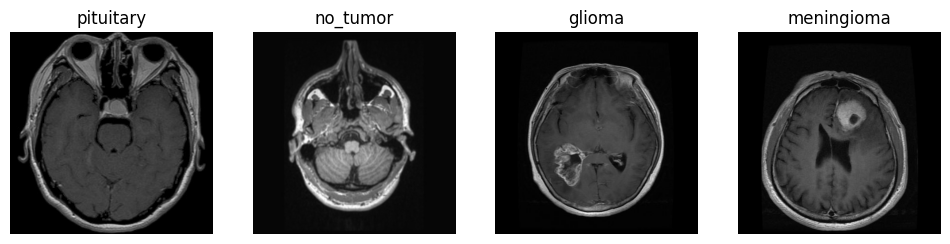

In [4]:
subfolders = list_subfolders(training_dir)
display_images_from_subfolders(training_dir, subfolders)

In [6]:
X_train, y_train = load_data(training_dir, labels)
X_test, y_test = load_data(testing_dir, labels)

In [7]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)

y_train = to_categorical(y_train) # One-hot encoding of integer labels
y_test = to_categorical(y_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) # 20% of the data is validation data

In [8]:
image_gen = ImageDataGenerator(
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
)

image_gen.fit(X_train)

In [10]:
models_dict = {
    'EfficientNet': build_and_compile_model('EfficientNet', 224),
    'DenseNet': build_and_compile_model('DenseNet', 224),
    'MobileNet': build_and_compile_model('MobileNet', 224),
    'ResNet50': build_and_compile_model('ResNet50', 224)
}

display_summaries(models_dict)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

In [12]:
history_dict = train_models(models_dict)


Epoch 1/10
160/160 [==============================] - ETA: 0s - loss: 0.2779 - accuracy: 0.9295 - auc: 0.9931
Epoch 1: val_loss improved from inf to 1.58756, saving model to EfficientNet.h5
160/160 [==============================] - 469s 3s/step - loss: 0.2779 - accuracy: 0.9295 - auc: 0.9931 - val_loss: 1.5876 - val_accuracy: 0.2772 - val_auc: 0.5345 - lr: 1.0000e-04
Epoch 2/10
160/160 [==============================] - ETA: 0s - loss: 0.1941 - accuracy: 0.9593 - auc: 0.9976
Epoch 2: val_loss improved from 1.58756 to 1.48773, saving model to EfficientNet.h5
160/160 [==============================] - 424s 3s/step - loss: 0.1941 - accuracy: 0.9593 - auc: 0.9976 - val_loss: 1.4877 - val_accuracy: 0.4800 - val_auc: 0.7307 - lr: 1.0000e-04
Epoch 3/10
160/160 [==============================] - ETA: 0s - loss: 0.1527 - accuracy: 0.9723 - auc: 0.9988
Epoch 3: val_loss did not improve from 1.48773
160/160 [==============================] - 424s 3s/step - loss: 0.1527 - accuracy: 0.9723 - auc: 

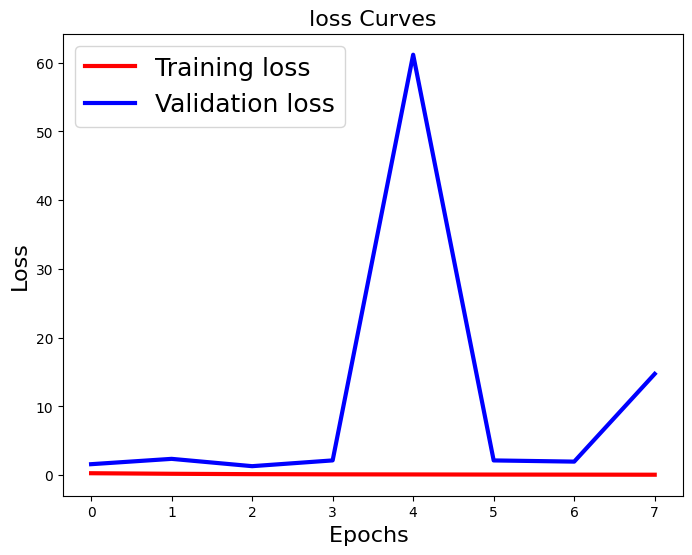

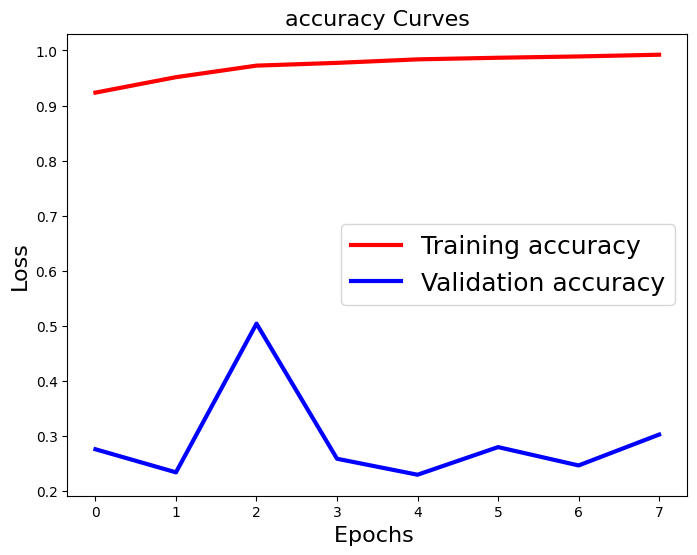

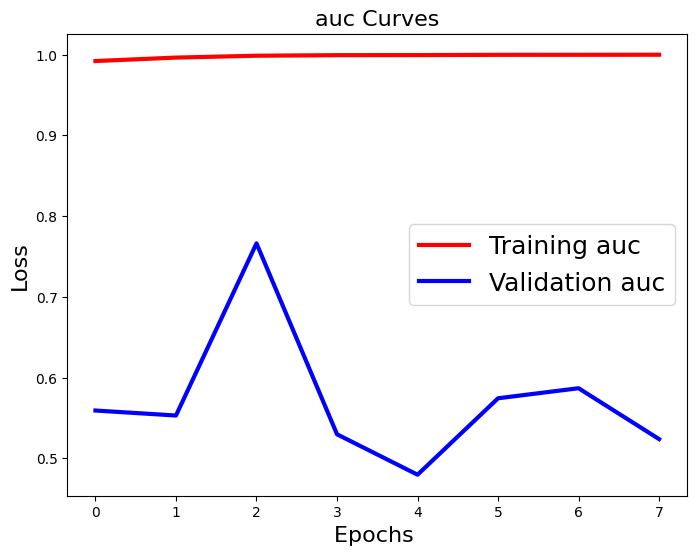

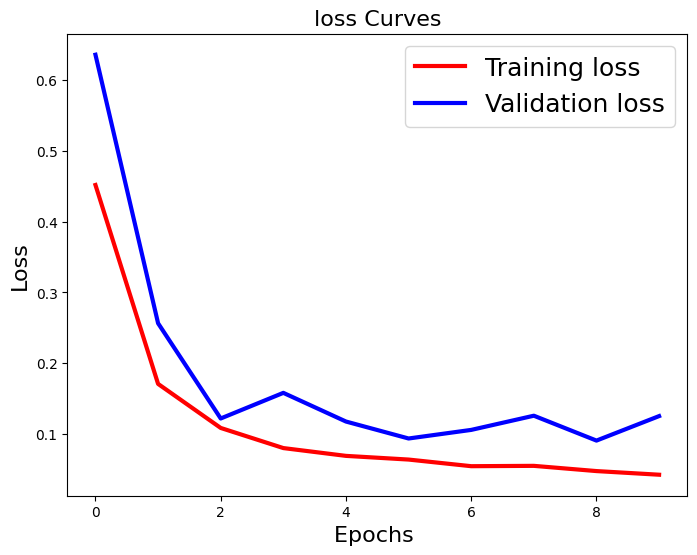

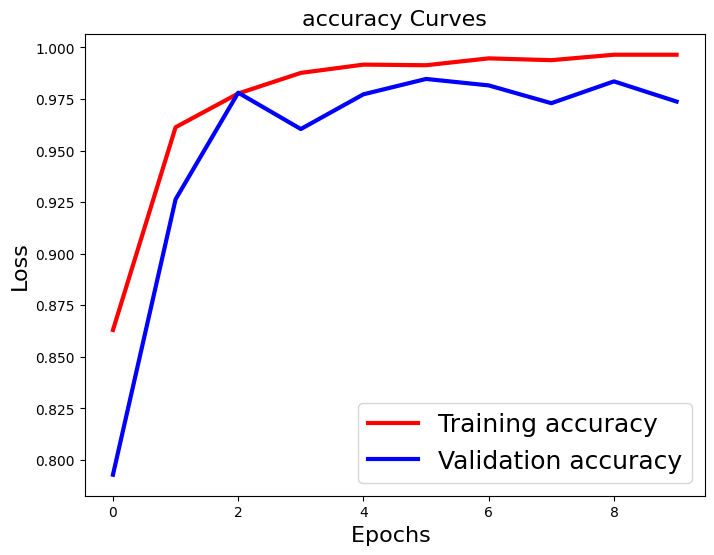

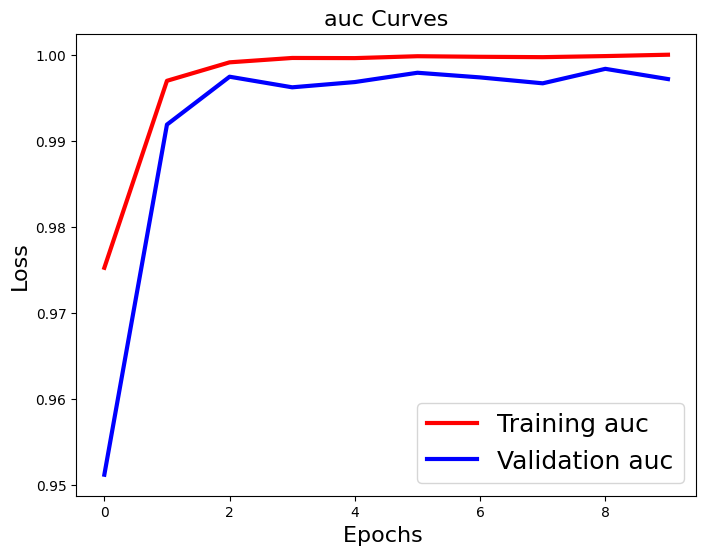

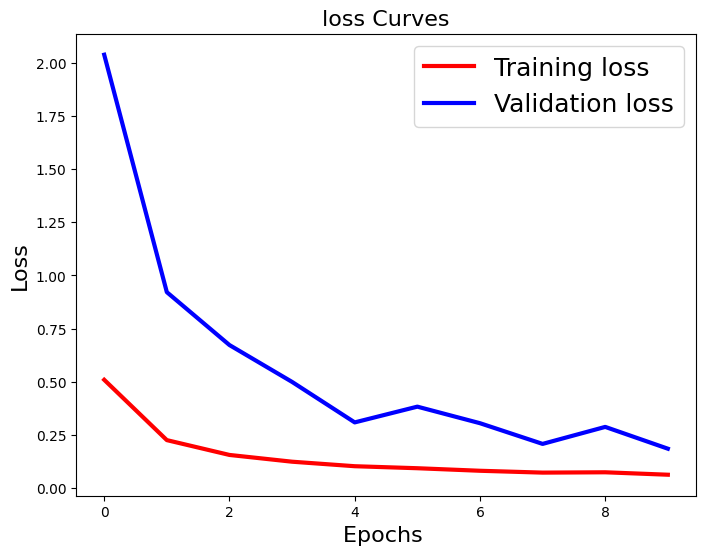

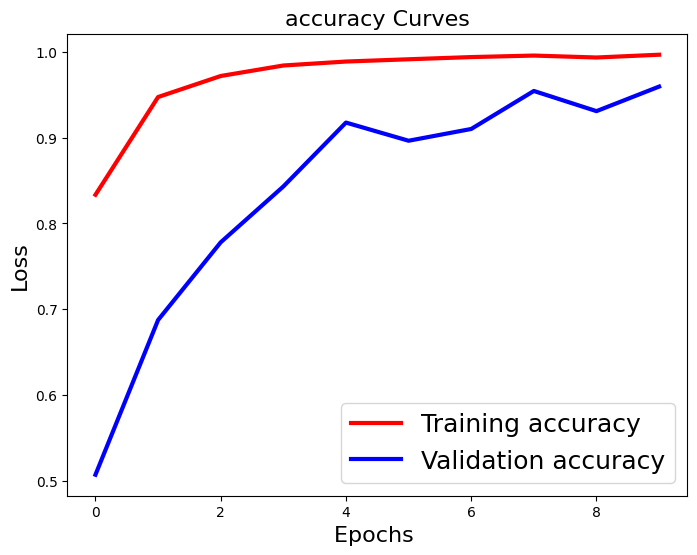

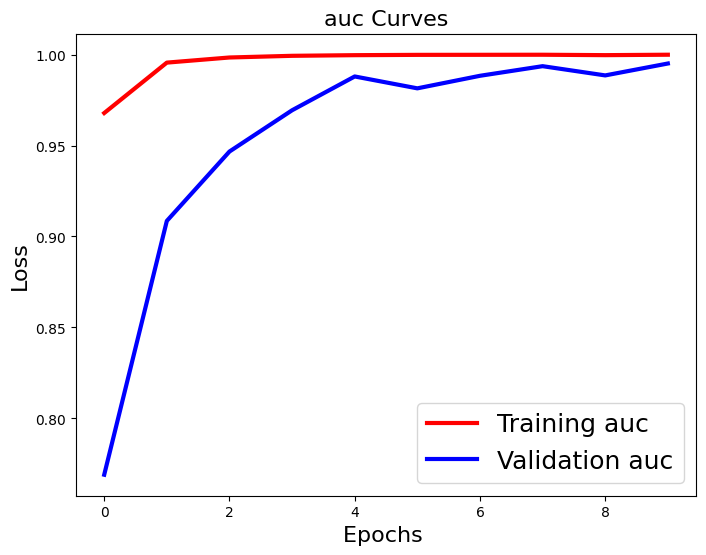

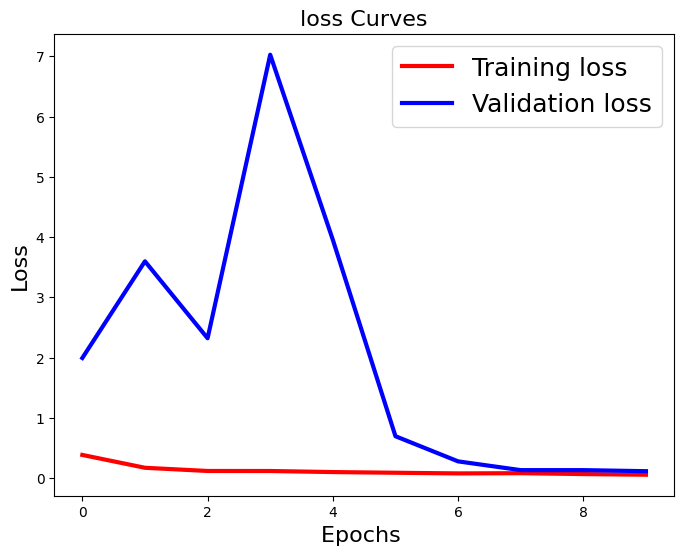

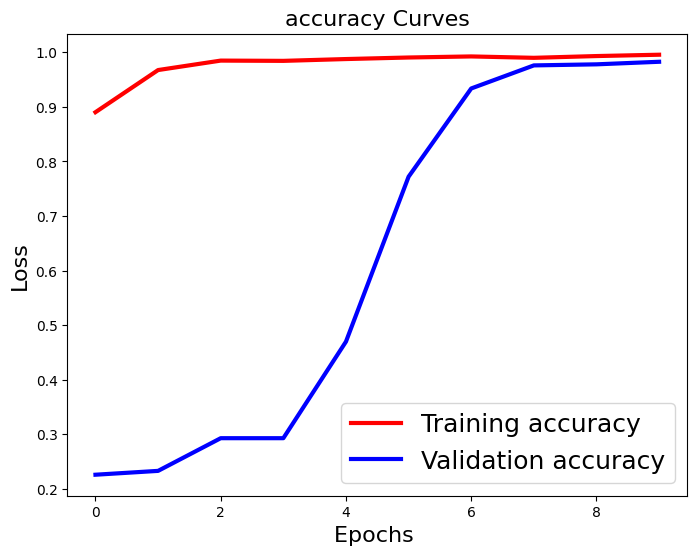

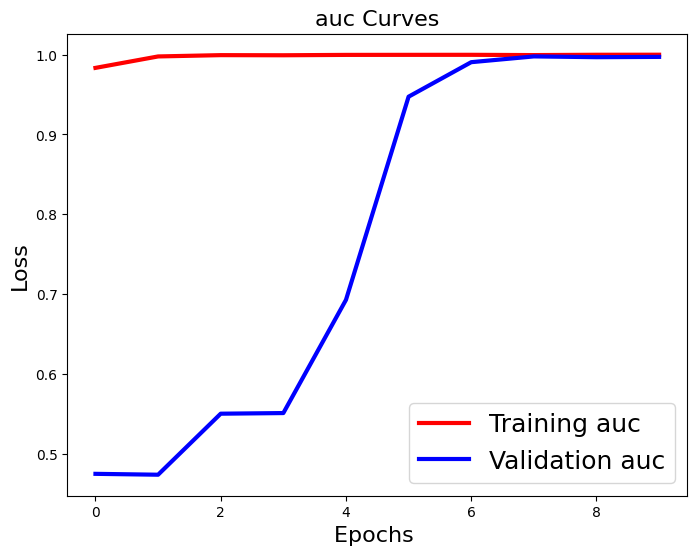

In [ ]:
def plot(metric, history):
    plt.figure(figsize=[8,6])
    plt.plot(history.history[metric], 'r', linewidth=3.0)
    plt.plot(history.history[f'val_{metric}'], 'b', linewidth=3.0)
    plt.legend([f'Training {metric}', f'Validation {metric}'], fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.title(f'{metric} Curves', fontsize=16)
    plt.show()
    
for model_name, history in history_dict.items():
    plot('loss', history)
    plot('accuracy', history)
    plot('auc', history)

54/54 [==============================] - 12s 215ms/step
              precision    recall  f1-score   support

           0       0.51      0.74      0.61       399
           1       0.88      0.47      0.61       421
           2       0.57      0.99      0.72       510
           3       1.00      0.05      0.09       374

    accuracy                           0.60      1704
   macro avg       0.74      0.56      0.51      1704
weighted avg       0.73      0.60      0.53      1704

54/54 [==============================] - 31s 568ms/step
              precision    recall  f1-score   support

           0       0.99      0.83      0.91       399
           1       0.90      0.99      0.95       421
           2       0.95      1.00      0.98       510
           3       0.99      0.98      0.98       374

    accuracy                           0.96      1704
   macro avg       0.96      0.95      0.95      1704
weighted avg       0.96      0.96      0.95      1704

54/54 [===========

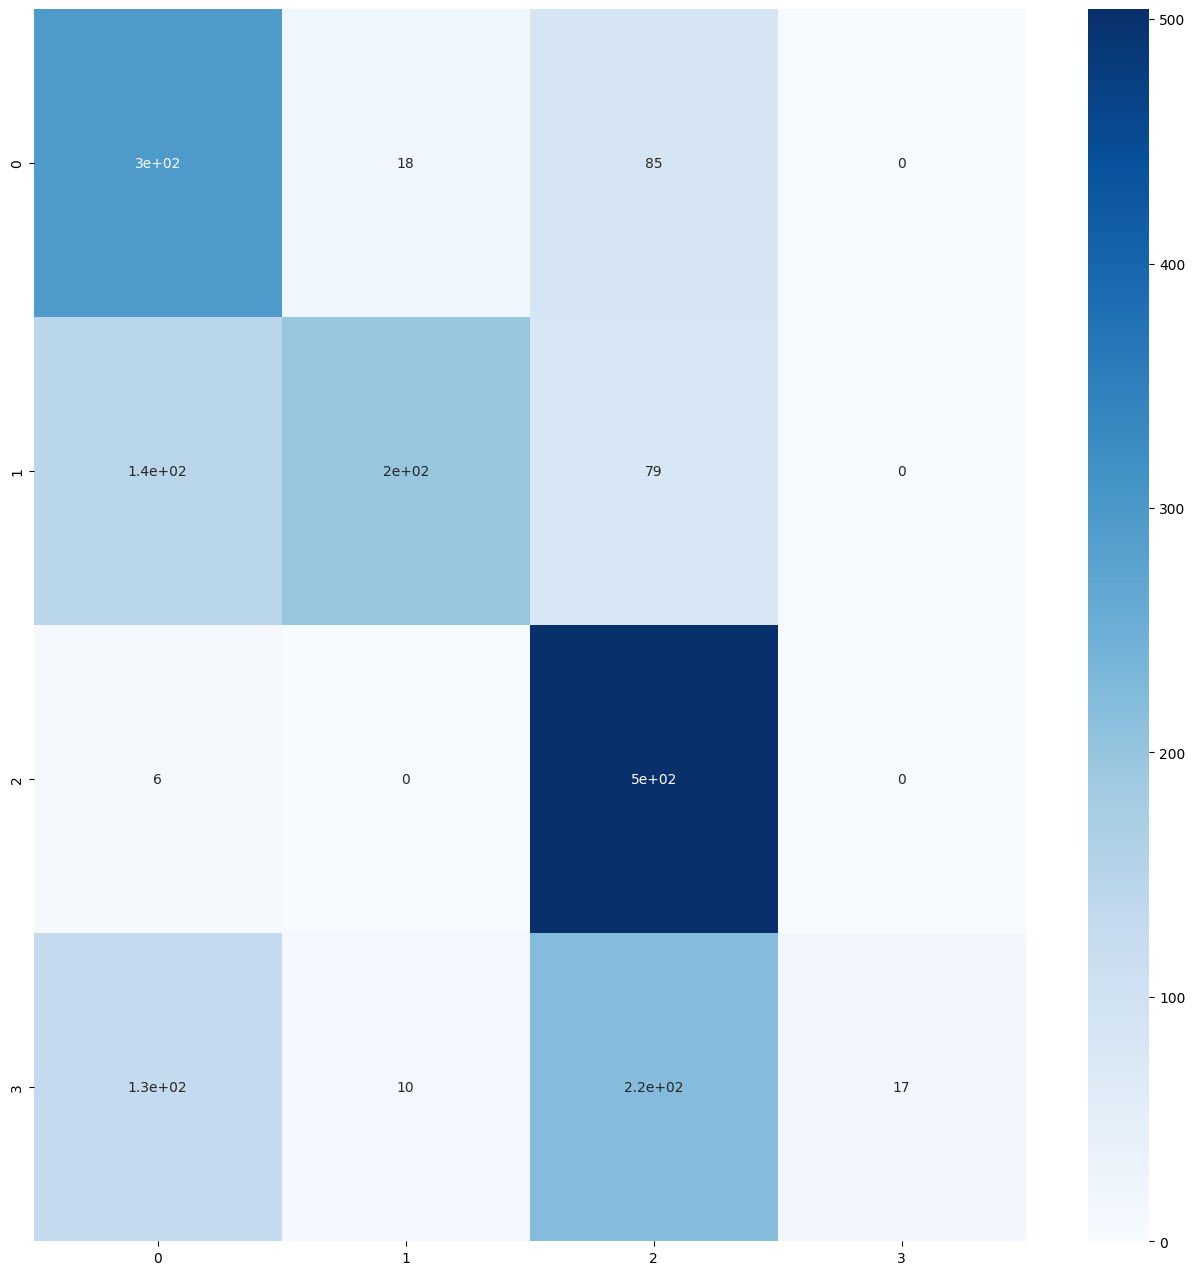

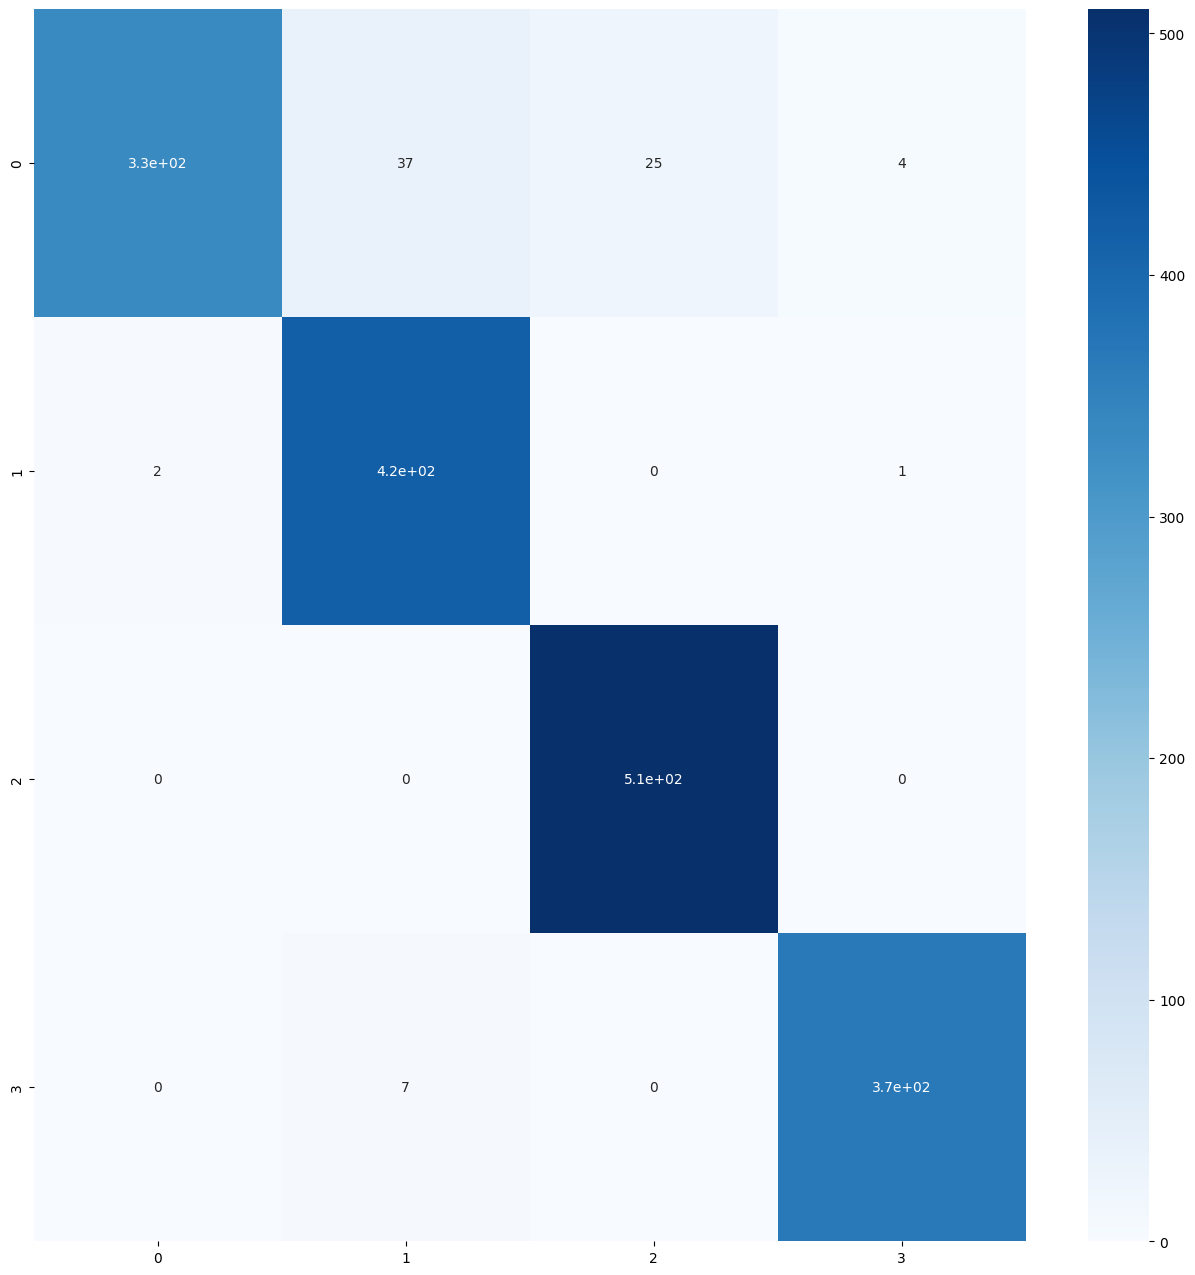

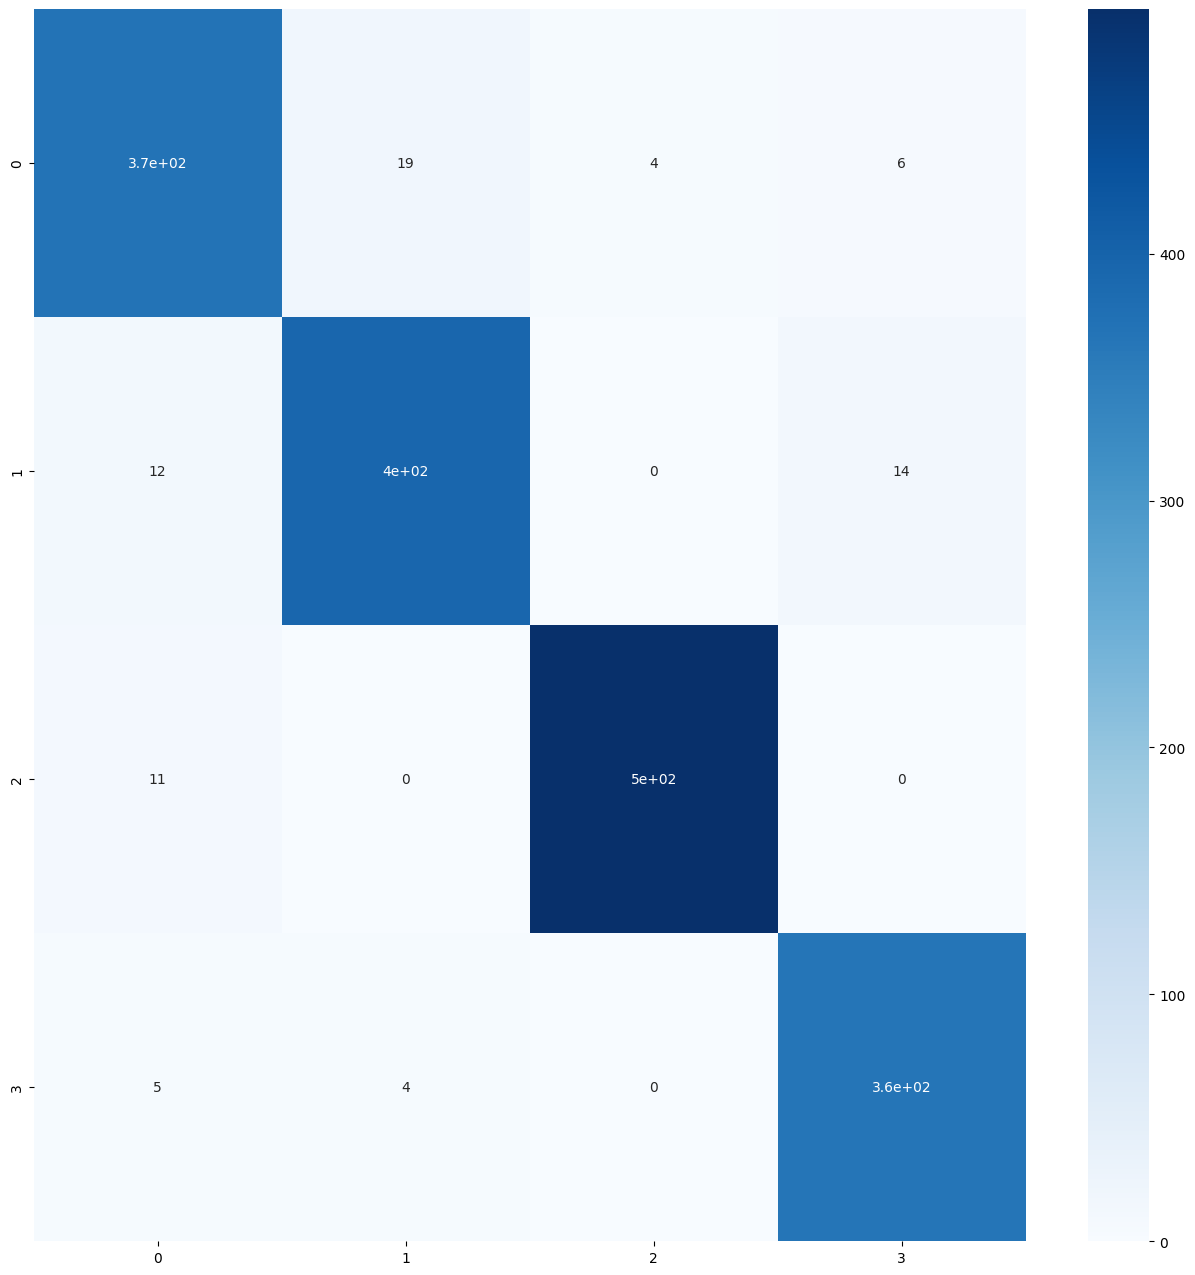

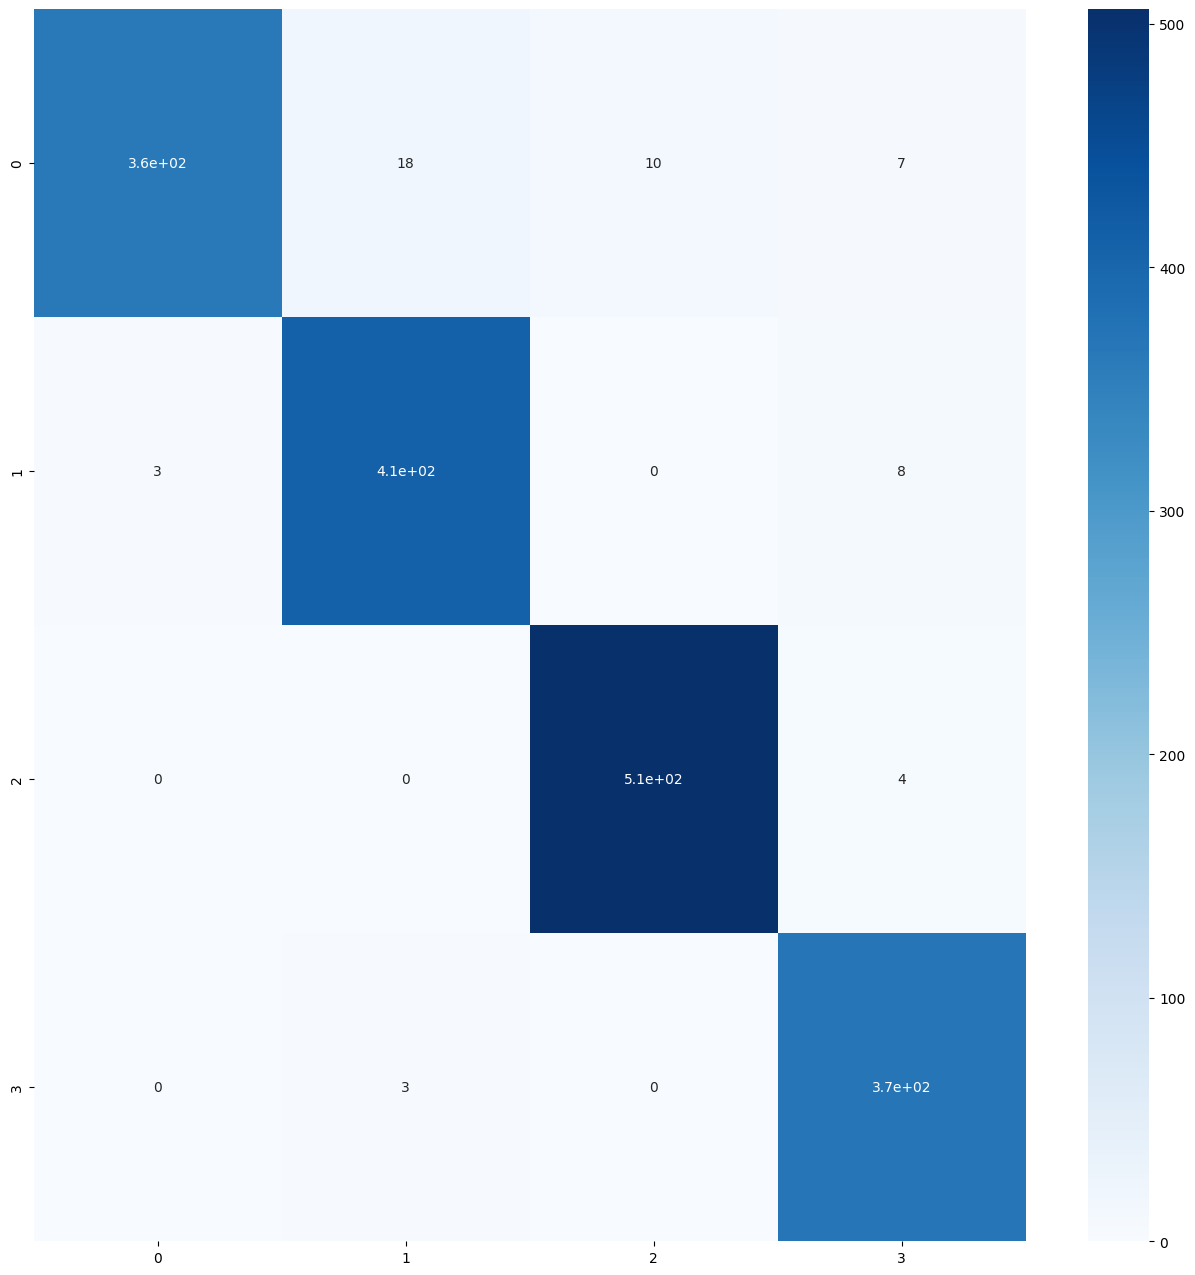

In [ ]:
for model_name, model in models_dict.items():
    predicted_classes = np.argmax(model.predict(X_test), axis=1)
    confusionmatrix = confusion_matrix(np.argmax(y_test,axis=1), predicted_classes)
    plt.figure(figsize = (16, 16))
    sns.heatmap(confusionmatrix, cmap='Blues', annot=True, cbar=True)

    print(classification_report(np.argmax(y_test,axis=1), predicted_classes))

In [ ]:
metrics_list = []

for model_name, model in models_dict.items():
    loss, acc, auc = model.evaluate(X_test, y_test)
    metrics_list.append([model_name, f"{acc * 100:.2f}%", f"{auc * 100:.2f}%", f"{loss:.2f}"])

df = pd.DataFrame(metrics_list, columns=["Model", "Accuracy (%)", "AUC (%)", "Loss"])

print(df)

54/54 [==============================] - 39s 713ms/step - loss: 0.1561 - accuracy: 0.9689 - auc: 0.9964
          Model Accuracy (%) AUC (%)  Loss
0  EfficientNet       59.51%  83.19%  1.12
1      DenseNet       95.54%  99.23%  0.19
2     MobileNet       95.60%  99.38%  0.20
3      ResNet50       96.89%  99.64%  0.16
